#II užduotis (Vieno neurono mokymas sprendžiant klasifikavimo uždavinį)

In [13]:
import csv, time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Duomenų įkėlimas ir paruošimas
def load_data(path: str):
    rows = []
    with open(path, "r") as f:
        for r in csv.reader(f):
            # atmetam eilutes su '?'
            if r and len(r) == 11 and "?" not in r[1:10]:
                rows.append(r)
    X, y = [], []
    for r in rows:
        feats = list(map(float, r[1:10]))  # be ID stulpelio
        lab = int(r[10])
        if lab == 2: y.append(0)   # 2 -> 0
        elif lab == 4: y.append(1) # 4 -> 1
        else: continue
        X.append(feats)
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], y[idx]

X, y = load_data(PATH)

In [15]:
# 80:10:10 padalinimas (mokymas / validavimas / testas)
n = len(X)
n_train = int(0.8*n)
n_val   = int(0.1*n)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

In [16]:
# Sigmoid, forward ir metrikos
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def forward(X, w, b):
    return sigmoid(X @ w + b)

def mse(y_true, y_hat):
    return np.mean((y_true - y_hat)**2)

def acc(y_true, y_prob):
    y_lab = (y_prob >= 0.5).astype(int)  # suapvalinimas į {0,1}
    return np.mean((y_lab == y_true).astype(float))

In [17]:
# 𝑤𝑘 ≔ 𝑤𝑘 − 𝜂 𝑦𝑖 − 𝑡𝑖 𝑦𝑖 (1 − 𝑦𝑖)(𝑥𝑖𝑘)
def train_sgd(X_tr, y_tr, X_va, y_va, lr=0.01, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    m, d = X_tr.shape
    w = rng.uniform(-0.01, 0.01, size=d)   # maži prad. svoriai
    b = rng.uniform(-0.01, 0.01)           # prad. bias

    tr_mse, va_mse, tr_acc, va_acc = [], [], [], []
    t0 = time.time()

    for _ in range(epochs):
        # permaišom įrašus
        for i in rng.permutation(m):
            xi = X_tr[i]        # požymiai
            ti = y_tr[i]        # klasė

            ai = float(np.dot(w, xi) + b)   # a_i = w·x + b linijinė
            yi = 1.0 / (1.0 + np.exp(-ai))  # y_i = σ(a_i) sigmoidinė

            # (y_i - t_i) * y_i*(1 - y_i)
            gc = (yi - ti) * yi * (1.0 - yi) # bendroji gradiento dalis

            # Atnaujinimai pagal formules: w_k := w_k - η*gc*x_{ik},  b := b - η*gc
            for k in range(d):
                w[k] -= lr * gc * xi[k] # skaidrių taisyklė
            b -= lr * gc

        # metrikos po epochos
        ytr = forward(X_tr, w, b)
        yva = forward(X_va, w, b)
        tr_mse.append(mse(y_tr, ytr))
        va_mse.append(mse(y_va, yva))
        tr_acc.append(acc(y_tr, ytr))
        va_acc.append(acc(y_va, yva))

    t1 = time.time()
    return w, b, np.array(tr_mse), np.array(va_mse), np.array(tr_acc), np.array(va_acc), (t1 - t0)

In [18]:
# 𝑤𝑘 ≔ 𝑤𝑘 − 𝜂 𝑦𝑖 − 𝑡𝑖 𝑦𝑖 (1 − 𝑦𝑖)(𝑥𝑖𝑘)
def train_bgd(X_tr, y_tr, X_va, y_va, lr=0.01, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    m, d = X_tr.shape
    w = rng.uniform(-0.01, 0.01, size=d)
    b = rng.uniform(-0.01, 0.01)

    tr_mse, va_mse, tr_acc, va_acc = [], [], [], []
    t0 = time.time()

    for _ in range(epochs):
        # Nulinam kaupiklius gradientui
        grad_w = np.zeros(d, dtype=float)
        grad_b = 0.0

        # kaupiam sumas: Σ_i (y_i - t_i) y_i(1 - y_i) * x_{ik}  ir  Σ_i (y_i - t_i) y_i(1 - y_i)
        for i in range(m):
            xi = X_tr[i]        # (d,)
            ti = y_tr[i]        # {0,1}

            ai = float(np.dot(w, xi) + b)
            yi = 1.0 / (1.0 + np.exp(-ai))

            gc_i = (yi - ti) * yi * (1.0 - yi)  # bendra dalis to įrašo

            for k in range(d):
                grad_w[k] += gc_i * xi[k]
            grad_b += gc_i

        # Apskaičiuojame vidurkius
        for k in range(d):
            grad_w[k] /= m
        grad_b /= m

        # atnaujinimas: w := w - η*∇w ,  b := b - η*∇b
        for k in range(d):
            w[k] -= lr * grad_w[k]
        b -= lr * grad_b

        # metrikos po epochos
        ytr = forward(X_tr, w, b)
        yva = forward(X_va, w, b)
        tr_mse.append(mse(y_tr, ytr))
        va_mse.append(mse(y_va, yva))
        tr_acc.append(acc(y_tr, ytr))
        va_acc.append(acc(y_va, yva))

    t1 = time.time()
    return w, b, np.array(tr_mse), np.array(va_mse), np.array(tr_acc), np.array(va_acc), (t1 - t0)

In [19]:
# Paleidimas su baziniu LR
w_sgd, b_sgd, tr_mse_sgd, va_mse_sgd, tr_acc_sgd, va_acc_sgd, time_sgd = train_sgd(X_train, y_train, X_val, y_val)
w_bgd, b_bgd, tr_mse_bgd, va_mse_bgd, tr_acc_bgd, va_acc_bgd, time_bgd = train_bgd(X_train, y_train, X_val, y_val)

# Testas (abiejų metodų)
yprob_sgd_test = forward(X_test, w_sgd, b_sgd)
yprob_bgd_test = forward(X_test, w_bgd, b_bgd)
test_mse_sgd, test_acc_sgd = mse(y_test, yprob_sgd_test), acc(y_test, yprob_sgd_test)
test_mse_bgd, test_acc_bgd = mse(y_test, yprob_bgd_test), acc(y_test, yprob_bgd_test)

print("==== SGD (bazinis LR) ====")
print(f"Svoriai (9): {w_sgd}\nBias: {b_sgd}\nLaikas: {time_sgd:.3f} s")
print(f"Train MSE={tr_mse_sgd[-1]:.6f}, Train ACC={tr_acc_sgd[-1]:.4f}")
print(f"Val   MSE={va_mse_sgd[-1]:.6f}, Val   ACC={va_acc_sgd[-1]:.4f}")
print(f"Test  MSE={test_mse_sgd:.6f}, Test  ACC={test_acc_sgd:.4f}")

print("\n==== BGD (bazinis LR) ====")
print(f"Svoriai (9): {w_bgd}\nBias: {b_bgd}\nLaikas: {time_bgd:.3f} s")
print(f"Train MSE={tr_mse_bgd[-1]:.6f}, Train ACC={tr_acc_bgd[-1]:.4f}")
print(f"Val   MSE={va_mse_bgd[-1]:.6f}, Val   ACC={va_acc_bgd[-1]:.4f}")
print(f"Test  MSE={test_mse_bgd:.6f}, Test  ACC={test_acc_bgd:.4f}")

==== SGD (bazinis LR) ====
Svoriai (9): [ 0.12115323  0.23138191  0.22557618  0.12524435 -0.16893395  0.31668797
  0.0146338   0.20244231  0.147165  ]
Bias: -3.9666745343449823
Laikas: 0.542 s
Train MSE=0.030626, Train ACC=0.9670
Val   MSE=0.010103, Val   ACC=1.0000
Test  MSE=0.018175, Test  ACC=0.9855

==== BGD (bazinis LR) ====
Svoriai (9): [-0.05397676  0.04828698  0.03651772  0.01834469 -0.03370874  0.08314296
 -0.01872588  0.04111101 -0.0186579 ]
Bias: -0.048211974697897154
Laikas: 0.448 s
Train MSE=0.198652, Train ACC=0.7509
Val   MSE=0.191201, Val   ACC=0.8382
Test  MSE=0.190665, Test  ACC=0.7681


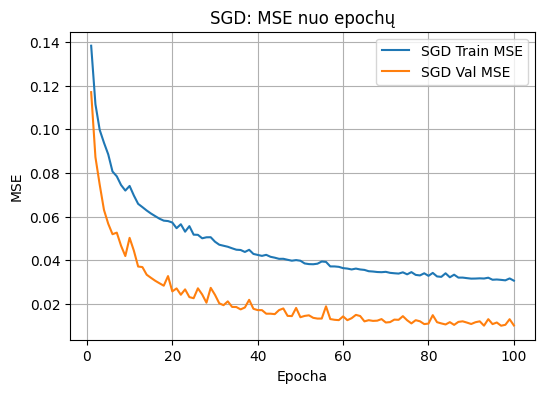

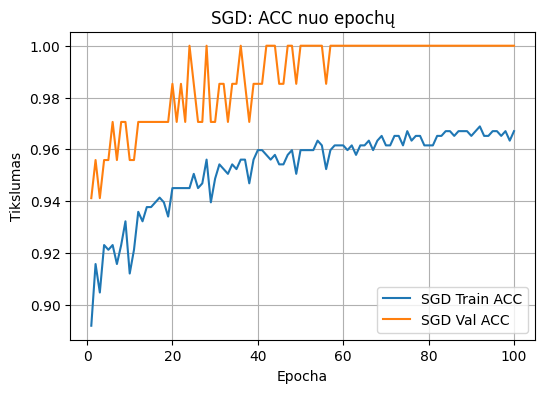

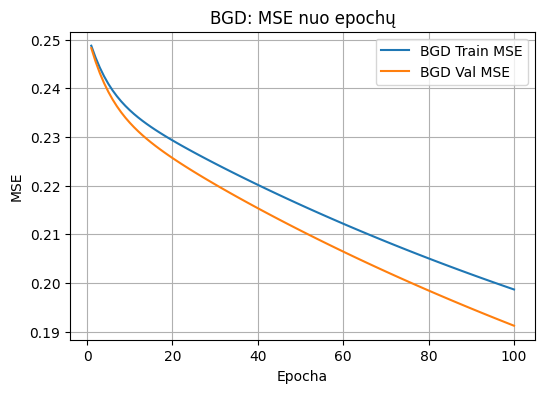

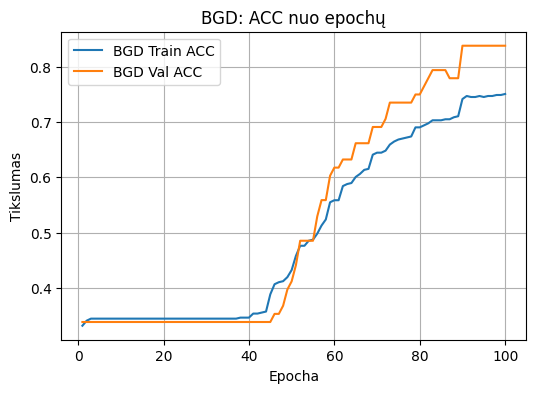

In [20]:
# Grafikai: MSE ir ACC priklausomybė nuo epochų (abiejų metodų)
epochs = np.arange(1, 101)

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_mse_sgd, label="SGD Train MSE")
plt.plot(epochs, va_mse_sgd, label="SGD Val MSE")
plt.title("SGD: MSE nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("MSE")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc_sgd, label="SGD Train ACC")
plt.plot(epochs, va_acc_sgd, label="SGD Val ACC")
plt.title("SGD: ACC nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("Tikslumas")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_mse_bgd, label="BGD Train MSE")
plt.plot(epochs, va_mse_bgd, label="BGD Val MSE")
plt.title("BGD: MSE nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("MSE")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc_bgd, label="BGD Train ACC")
plt.plot(epochs, va_acc_bgd, label="BGD Val ACC")
plt.title("BGD: ACC nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("Tikslumas")
plt.legend(); plt.grid(True); plt.show()

In [21]:
# LR tyrimas (≥3 reikšmės)
results = []  # (method, lr, test_mse, test_acc, time)
LR_LIST = [0.001, 0.01, 0.1]
for lr in LR_LIST:
    w, b, *_ , t = train_sgd(X_train, y_train, X_val, y_val, lr=lr)
    results.append(("SGD", lr, mse(y_test, forward(X_test, w, b)), acc(y_test, forward(X_test, w, b)), t))
    w, b, *_ , t = train_bgd(X_train, y_train, X_val, y_val, lr=lr)
    results.append(("BGD", lr, mse(y_test, forward(X_test, w, b)), acc(y_test, forward(X_test, w, b)), t))

print("\n=== LR tyrimas (testo rodikliai ir mokymo laikas) ===")
print("Metodas  LR       Test MSE     Test ACC     Laikas (s)")
for m, lr, tmse, tacc, tt in results:
    print(f"{m:6s}  {lr:<6}  {tmse:10.6f}   {tacc:9.4f}    {tt:8.3f}")


=== LR tyrimas (testo rodikliai ir mokymo laikas) ===
Metodas  LR       Test MSE     Test ACC     Laikas (s)
SGD     0.001     0.061574      0.9710       0.493
BGD     0.001     0.226152      0.4058       0.432
SGD     0.01      0.018175      0.9855       0.491
BGD     0.01      0.190665      0.7681       0.448
SGD     0.1       0.015665      0.9855       0.491
BGD     0.1       0.111112      0.9130       0.442


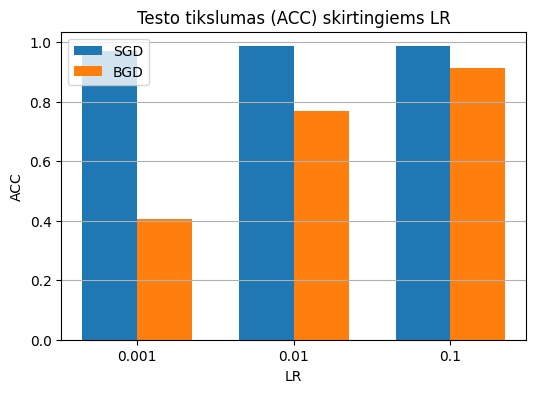

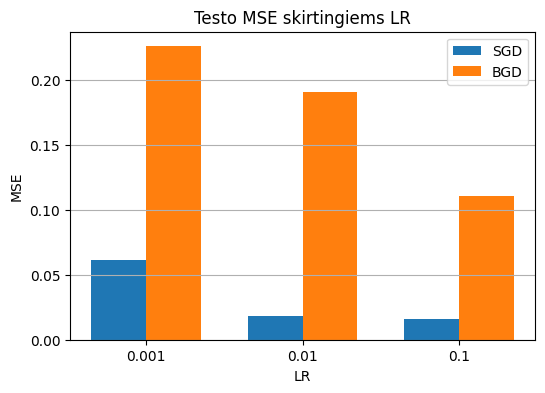

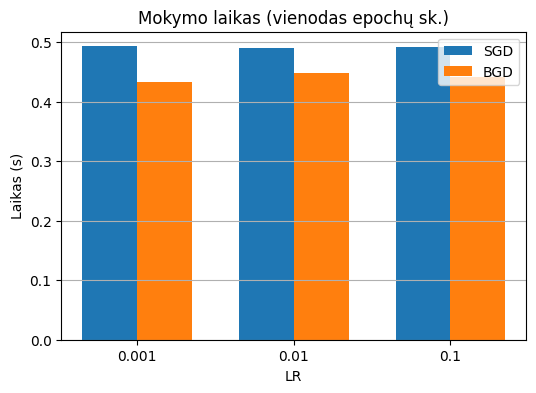

In [22]:
def _bar_data(metric_idx):
    sgd_vals = [r[metric_idx] for r in results if r[0]=="SGD"]
    bgd_vals = [r[metric_idx] for r in results if r[0]=="BGD"]
    return sgd_vals, bgd_vals

x = np.arange(len(LR_LIST)); width = 0.35
sgd_accs, bgd_accs = _bar_data(3)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, sgd_accs, width, label="SGD")
plt.bar(x + width/2, bgd_accs, width, label="BGD")
plt.xticks(x, [str(lr) for lr in LR_LIST])
plt.title("Testo tikslumas (ACC) skirtingiems LR"); plt.xlabel("LR"); plt.ylabel("ACC")
plt.legend(); plt.grid(True, axis='y'); plt.show()

sgd_mses, bgd_mses = _bar_data(2)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, sgd_mses, width, label="SGD")
plt.bar(x + width/2, bgd_mses, width, label="BGD")
plt.xticks(x, [str(lr) for lr in LR_LIST])
plt.title("Testo MSE skirtingiems LR"); plt.xlabel("LR"); plt.ylabel("MSE")
plt.legend(); plt.grid(True, axis='y'); plt.show()

sgd_ts, bgd_ts = _bar_data(4)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, sgd_ts, width, label="SGD")
plt.bar(x + width/2, bgd_ts, width, label="BGD")
plt.xticks(x, [str(lr) for lr in LR_LIST])
plt.title("Mokymo laikas (vienodas epochų sk.)"); plt.xlabel("LR"); plt.ylabel("Laikas (s)")
plt.legend(); plt.grid(True, axis='y'); plt.show()


In [23]:
# Testavimo įrašų lentelė: SGD ir BGD šalia
def spausdinti_testo_irasus_salia(y_true, yprob_sgd, yprob_bgd):
    y_true = np.asarray(y_true, int)
    yprob_sgd = np.asarray(yprob_sgd, float); ypred_sgd = (yprob_sgd >= 0.5).astype(int)
    yprob_bgd = np.asarray(yprob_bgd, float); ypred_bgd = (yprob_bgd >= 0.5).astype(int)
    n = len(y_true); w = len(str(n))
    fmt = f"{{:>{w}}}  {{:>5}}  {{:>8}}  {{:>9}}  {{:>8}}  {{:>9}}"
    header = fmt.format("#", "tikra", "SGD_prog", "SGD_prob", "BGD_prog", "BGD_prob")
    print(f"\nTesto įrašai (n={n}, slenkstis=0.5):"); print(header); print("-"*len(header))
    for i, (t, ps, pb, pps, ppb) in enumerate(zip(y_true, ypred_sgd, ypred_bgd, yprob_sgd, yprob_bgd), 1):
        print(fmt.format(i, t, ps, f"{pps:.6f}", pb, f"{ppb:.6f}"))

spausdinti_testo_irasus_salia(y_test, yprob_sgd_test, yprob_bgd_test)


Testo įrašai (n=69, slenkstis=0.5):
 #  tikra  SGD_prog   SGD_prob  BGD_prog   BGD_prob
---------------------------------------------------
 1      0         0   0.057373         0   0.491610
 2      0         0   0.123985         0   0.460107
 3      0         0   0.097133         0   0.495783
 4      0         0   0.082688         0   0.442026
 5      1         1   0.986957         1   0.605589
 6      1         1   0.955264         1   0.662377
 7      1         1   0.990406         1   0.753662
 8      1         1   0.843721         1   0.582085
 9      0         0   0.032365         0   0.470493
10      1         1   0.956425         1   0.659253
11      0         0   0.087349         1   0.534033
12      0         0   0.093042         0   0.464490
13      0         0   0.051161         1   0.505103
14      0         0   0.081102         0   0.487290
15      1         1   0.989688         1   0.683991
16      0         0   0.065173         0   0.473458
17      0         0   0.057